In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load datasets
customers_path = "Customers.csv"
transactions_path = "Transactions.csv"

customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)

In [3]:
# Merge datasets on CustomerID
merged_df = pd.merge(customers_df, transactions_df, on="CustomerID", how="inner")

In [4]:
# Aggregate transaction data for each customer
customer_transactions = (
    merged_df.groupby("CustomerID")
    .agg(
        TotalTransactions=("TransactionID", "count"),
        TotalQuantity=("Quantity", "sum"),
        TotalSpent=("TotalValue", "sum"),
        AvgTransactionValue=("TotalValue", "mean"),
    )
    .reset_index()
)

In [5]:
# Combine with customer profile data
customer_profile = pd.merge(customers_df, customer_transactions, on="CustomerID", how="left")


In [6]:
# Select features for clustering
features = ["TotalTransactions", "TotalQuantity", "TotalSpent", "AvgTransactionValue"]
X = customer_profile[features].fillna(0)  # Handle missing values

In [7]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
# Perform clustering and evaluate with DB Index for clusters ranging from 2 to 10
db_scores = []
k_range = range(2, 11)

In [9]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    db_index = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db_index)

D:\Users\ACER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Users\ACER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Users\ACER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Users\ACER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows wi

In [10]:
# Find the optimal number of clusters (lowest DB Index)
optimal_k = k_range[db_scores.index(min(db_scores))]

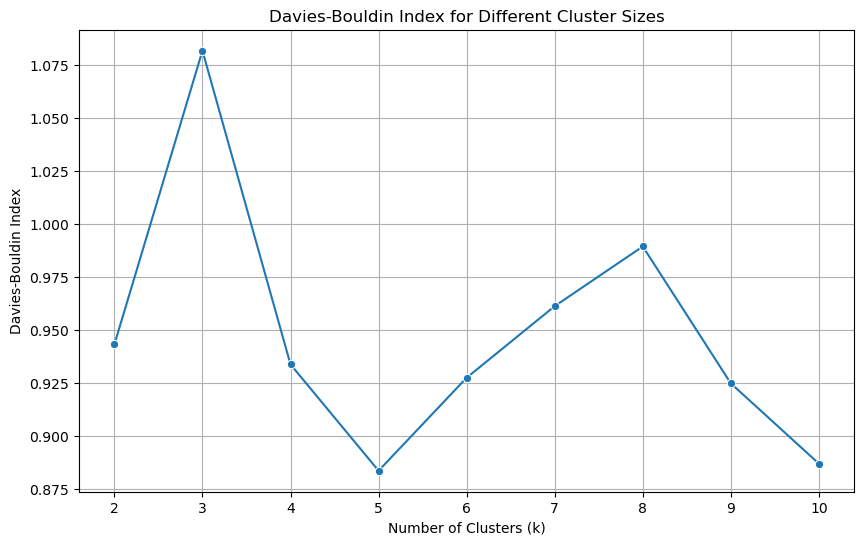

In [11]:
# Visualize DB Index scores
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(k_range), y=db_scores, marker="o")
plt.title("Davies-Bouldin Index for Different Cluster Sizes")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.xticks(k_range)
plt.grid()
plt.show()

In [12]:
# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_profile["Cluster"] = kmeans.fit_predict(X_scaled)

D:\Users\ACER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<Axes: xlabel='TotalSpent', ylabel='TotalTransactions'>

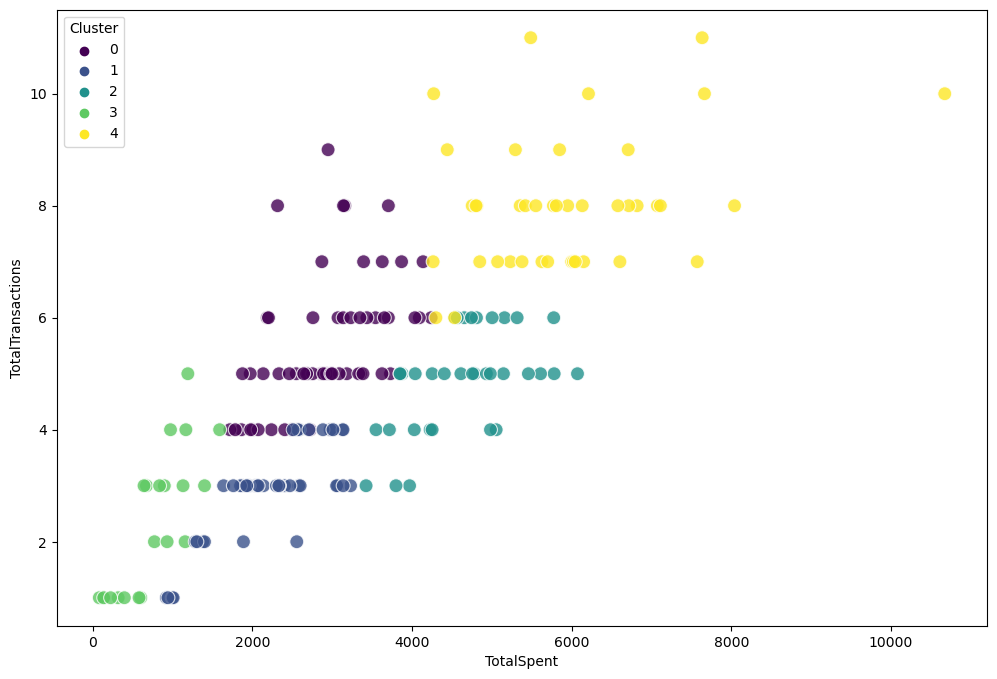

In [13]:
# Visualize the clusters in 2D space using TotalSpent and TotalTransactions
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=customer_profile["TotalSpent"],
    y=customer_profile["TotalTransactions"],
    hue=customer_profile["Cluster"],
    palette="viridis",
    s=100,
    alpha=0.8,
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


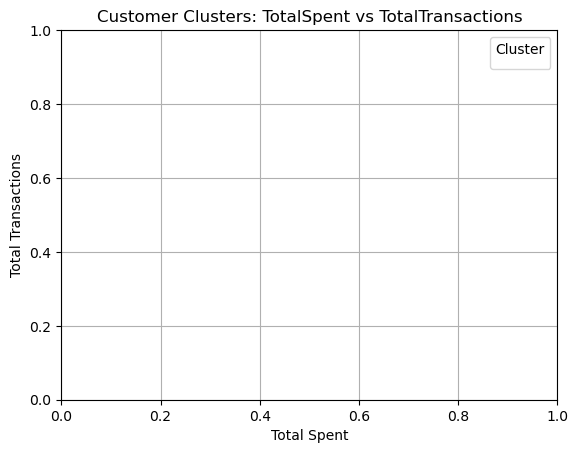

In [14]:
plt.title("Customer Clusters: TotalSpent vs TotalTransactions")
plt.xlabel("Total Spent")
plt.ylabel("Total Transactions")
plt.legend(title="Cluster", loc="upper right")
plt.grid()
plt.show()


In [16]:
# Save the clustered data to a CSV file
customer_profile.to_csv("Clustered.csv", index=False)